### NIR spectroscopy and PCA

In [ ]:
# NIR data from Spectrum 100N
import os, sys
import pandas as pd
import cv2
import numpy as np
pd .options.display.max_rows = 10
df = pd.read_csv('../../../GitHubData/DataScience_AI/data/Spectroscopy/Data_of_4_Meranti species.csv')

Firstly, plotting all the data to see their visual appearence.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

wavnum = np.flip(df.axes[1][1:])
wvnm= wavnum.astype(float)
sp_data=np.flip(df.values[:,1:],axis=1)
plt.figure(figsize=(12,6))
plt.plot(wvnm,sp_data[2:32].T)
plt.title("Whole spectra", fontsize=16)
plt.xlabel("wavenumber cm-1", fontsize=16)
plt.grid(which="both")
plt.gca().invert_xaxis()
plt.tick_params(labelsize=14) 

plt.show()

- Fig. Calculate 2nd derivative spectra by Savitzky-Golay algorithm. Window-size = 35, fitting function order = 3, seems reasonable. Window-size more than 41 seems to spoil the small peaks around 4000 cm-1. Spectral region 9000 - 10000 should be negrected.

In [ ]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    """
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial
    
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError :
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

In [ ]:
plt.figure(figsize=(12,6))
y1 = sp_data[10,:]
y2 = savitzky_golay(y1,35,3,2)
plt.plot(wvnm,y2*500+0.5)
plt.plot(wvnm,y1.T+0.6)
plt.title("Whole and 2nd derivative spectra", fontsize=16)
plt.xlabel("wavenumber cm-1", fontsize=16)
plt.grid()
plt.tick_params(labelsize=14) 
plt.gca().invert_xaxis()

In [ ]:
df_2nd = []
for n in list(range(len(df.axes[0]))):
    x = df.values[n,1:]
    df_2nd.append(savitzky_golay(x,35,3,2))
X_data = np.flip(np.asarray(df_2nd),axis=1)
target_names=np.unique(df.values[:,0])
tmp = pd.get_dummies(df.values[:,0])
X_category = tmp.values.argmax(1) # make strings into numbers 0,1,2,...
sp_names = df.values[:,0]

In [ ]:
df=pd.read_excel('../../../GitHubData/Datascience_AI/data/Spectroscopy/2nd_Meranti.xlsx', index_col=0)
df.head() # DataFrameの最初の5行を書き出します

In [ ]:
df.shape
target_names=np.unique(df.index)
tmp = pd.get_dummies(df.index)
X_category = tmp.values.argmax(1) # make strings into numbers 0,1,2,...
sp_names = df.index
sp_names

##  ここから下のスクリプトがテキストにあるものと同じ、データは二次微分データから使うように変更したもの。

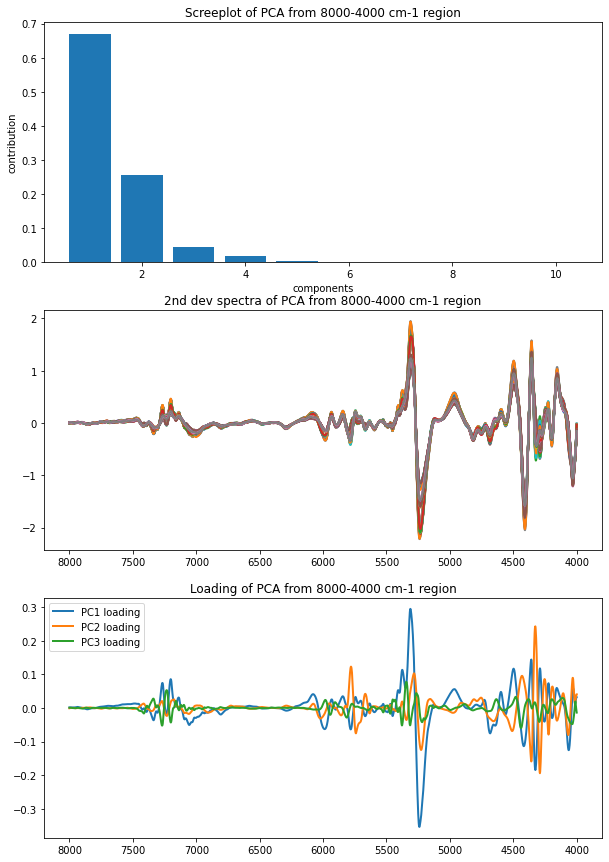

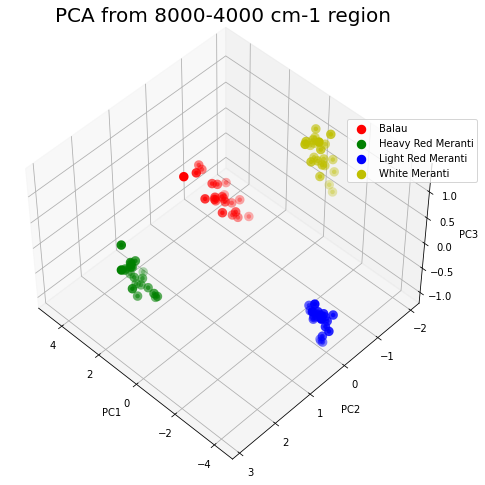

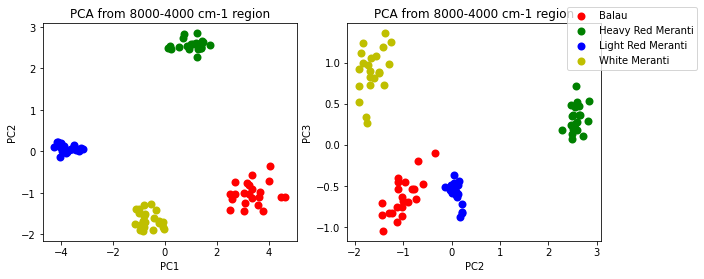

In [1]:
# PCA analyses : wavenuber range  8000-4000 cm-1
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

df=pd.read_excel('../../../GitHubData/Datascience_AI/data/Spectroscopy/2nd_Meranti.xlsx', index_col=0)

target_names=np.unique(df.index)
tmp = pd.get_dummies(df.index)
X_category = tmp.values.argmax(1) # make strings into numbers 0,1,2,...
sp_names = df.index


X = df
X = X*10e3  # 
title = "PCA from 8000-4000 cm-1 region"

pca = PCA(n_components=10)
X_r = pca.fit(X).transform(X)
        

fig, axes = plt.subplots(nrows=3, figsize=(10,15))
#　寄与率
axes[0].bar(np.arange(1,11,1), pca.explained_variance_ratio_, align = "center")
axes[0].set_title("Screeplot of "+title)
axes[0].set_xlabel("components")
axes[0].set_ylabel("contribution")
# ２次微分曲線
axes[1].plot(df.columns,X.T,linewidth = 2 ) ## x 10e3 
axes[1].set_title("2nd dev spectra of "+title)
axes[1].invert_xaxis()
# 因子付加量
loadings = pca.components_*np.c_[np.sqrt(pca.explained_variance_)]
axes[2].plot(df.columns,loadings[0],linewidth = 2, label='PC1 loading')
axes[2].plot(df.columns,loadings[1],linewidth = 2, label='PC2 loading' )
axes[2].plot(df.columns,loadings[2],linewidth = 2, label='PC3 loading' )
axes[2].set_title("Loading of "+title)
axes[2].invert_xaxis()
axes[2].legend()
plt.show()


        
#PCA 3D plot
colors = ['r', 'g', 'b','y' ]
fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
plt.cla()
lw=5
for color, i, target_name in zip(colors, list(range(max(X_category)+1)), target_names):
    ax.scatter(X_r[X_category==i, 0], X_r[X_category==i, 1], X_r[X_category==i, 2], color=color, lw=lw, label=target_name) 
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title(title, fontsize=20)
ax.legend(bbox_to_anchor=(1.1, 0.8), shadow=False, scatterpoints=1)
         
# PCA
fig, axes = plt.subplots(ncols=2,figsize=(10,4))
lw = 2 # line width
for color, i, target_name in zip(colors, list(range(max(X_category)+1)), target_names):
    axes[0].scatter(X_r[X_category == i, 0], X_r[X_category == i, 1], color=color,lw=lw,label=target_name)
axes[0].set_title(title)
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')

for color, i, target_name in zip(colors, list(range(max(X_category)+1)), target_names):
    axes[1].scatter(X_r[X_category == i, 1], X_r[X_category == i, 2], color=color, lw=lw,label=target_name)
axes[1].legend(bbox_to_anchor=(1.4, 1.1), shadow=False, scatterpoints=1)
axes[1].set_title(title)
axes[1].set_xlabel('PC2')
axes[1].set_ylabel('PC3')
plt.show()


#### End of program

In [2]:
pca.explained_variance_ratio_

array([6.70204392e-01, 2.55560104e-01, 4.44736998e-02, 1.85856845e-02,
       2.46105314e-03, 1.03995166e-03, 9.05300057e-04, 7.28748290e-04,
       5.91770693e-04, 4.82452749e-04])